In [52]:
import wetter_api as wt
import waldbrand
import model_eval as me
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, r2_score
import logging
import pandas as pd
import common_paths
import seaborn as sb
import plotly.express as pl

In [53]:
parameter_list = [
    wt.DwdObservationParameter.MONTHLY.PRECIPITATION_HEIGHT,
    wt.DwdObservationParameter.MONTHLY.CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT,
    wt.DwdObservationParameter.MONTHLY.TEMPERATURE_AIR_MAX_200,
]
# Dictionary with short names as keys and full names as values
shortname_to_state = {
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "BE": "Berlin",
    "BB": "Brandenburg",
    "HB": "Bremen",
    "HH": "Hamburg",
    "HE": "Hessen",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "SH": "Schleswig-Holstein",
    "TH": "Thüringen",
}

# Example usage
shortname = "BB"
state = shortname_to_state.get(shortname)

In [54]:
nr = me.prepare_data(parameter_list, state, "nr")

In [55]:
area = me.prepare_data(parameter_list, state, "area")

In [56]:
nr

Year  Month station_id  CLIMATE_SUMMARY.PRECIPITATION_HEIGHT  \
0     1995      1      00164                                  42.5   
1     1995      1      00427                                  43.5   
2     1995      1      00650                                  71.3   
3     1995      1      00880                                  47.1   
4     1995      1      01001                                  52.0   
...    ...    ...        ...                                   ...   
8376  2022     12      05745                                  53.9   
8377  2022     12      05825                                  45.4   
8378  2022     12      06170                                  42.3   
8379  2022     12      06265                                  58.2   
8380  2022     12      07389                                  40.7   

      CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT  \
0                                    3.46   
1                                    3.34   
2                                    2.42   
3                                    2.74   
4                                    3.39   
...                                   ...   
8376                                  NaN   
8377                                 2.29   
8378                                  NaN   
8379                                  NaN   
8380                                 2.26   

      CLIMATE_SUMMARY.TEMPERATURE_AIR_MAX_200  nFires  
0                                      285.35     0.0  
1                                      285.75     0.0  
2                                      285.65     0.0  
3                                      286.15     0.0  
4                                      285.75     0.0  
...                                       ...     ...  
8376                                   288.75     0.0  
8377                                   289.95     0.0  
8378                                   291.25     0.0  
8379                                   290.95     0.0  
8380                                   290.05     0.0  

[8381 rows x 7 columns]

In [57]:
area

Year  Month station_id  CLIMATE_SUMMARY.PRECIPITATION_HEIGHT  \
0     1995      1      00164                                  42.5   
1     1995      1      00427                                  43.5   
2     1995      1      00650                                  71.3   
3     1995      1      00880                                  47.1   
4     1995      1      01001                                  52.0   
...    ...    ...        ...                                   ...   
8376  2022     12      05745                                  53.9   
8377  2022     12      05825                                  45.4   
8378  2022     12      06170                                  42.3   
8379  2022     12      06265                                  58.2   
8380  2022     12      07389                                  40.7   

      CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT  \
0                                    3.46   
1                                    3.34   
2                                    2.42   
3                                    2.74   
4                                    3.39   
...                                   ...   
8376                                  NaN   
8377                                 2.29   
8378                                  NaN   
8379                                  NaN   
8380                                 2.26   

      CLIMATE_SUMMARY.TEMPERATURE_AIR_MAX_200 area  
0                                      285.35  NaN  
1                                      285.75  NaN  
2                                      285.65  NaN  
3                                      286.15  NaN  
4                                      285.75  NaN  
...                                       ...  ...  
8376                                   288.75  0.0  
8377                                   289.95  0.0  
8378                                   291.25  0.0  
8379                                   290.95  0.0  
8380                                   290.05  0.0  

[8381 rows x 7 columns]

In [58]:
area.to_csv(common_paths.DATA.joinpath("dwd/area_Brandenburg.csv"))

In [59]:
nr.to_csv(common_paths.DATA.joinpath("dwd/nr_Brandenburg.csv"))

In [60]:
nr = nr.where(nr.Year>=1995).where(nr.Year<=2022)

In [61]:
nr.rename(columns={'CLIMATE_SUMMARY.PRECIPITATION_HEIGHT':'pr', 'CLIMATE_SUMMARY.WIND_FORCE_BEAUFORT':'sfcWind', 'CLIMATE_SUMMARY.TEMPERATURE_AIR_MAX_200':'tasmax'}, inplace=True)

In [62]:
nr.groupby(['station_id']).count()

Year  Month   pr  sfcWind  tasmax  nFires
station_id                                           
00096         44     44   44       37      44      44
00164        336    336  336      333     336     336
00303        299    299  296      246     272     299
00427        336    336  335      335     336     336
00650         76     76   76       76      76      76
00879         13     13    0       10       0      13
00880        336    336  336      327     336     336
01001        336    336  335      320     336     336
01106          0      0    0        0       0       0
01426          0      0    0        0       0       0
01552         16     16   16        6       6      16
01869        311    311  255      266     283     311
02289          0      0    0        0       0       0
02315        268    268    0      254       0     268
02475          0      0    0        0       0       0
02621          0      0    0        0       0       0
02627        318    318  318      186     318     318
02794        312    312  264      275     294     312
02856        336    336  335      323     336     336
02951        336    336  336      203     336     336
03015        336    336  336      335     336     336
03082          0      0    0        0       0       0
03083        336    336  335      203     335     336
03158        332    332  331      316     332     332
03376        335    335  333      322     335     335
03509        219    219  218       87     219     219
03552        291    291  290      285     290     291
03915          0      0    0        0       0       0
03987        336    336  336      336     336     336
03988        300    300  299      299     300     300
04606          0      0    0        0       0       0
05463         43     43   43       43      43      43
05546        335    335  267      291     319     335
05643        336    336  336      204     336     336
05728          0      0    0        0       0       0
05745        334    334  330      203     333     334
05825        335    335  334      323     335     335
06086         32     32   32       30      32      32
06170        275    275  273      143     275     275
06265        224    224  223       92     224     224
07244        116    116  116      112     115     116
07389        193    193  191      168     193     193

In [63]:
nr['sfcWind'] =  0.836 * (nr['sfcWind'] ** 1.5)

In [64]:
nr.drop(columns=["station_id"], inplace=True)

In [65]:
nr.dropna(inplace=True)

In [66]:
nr

Year  Month    pr   sfcWind  tasmax  nFires
0     1995      1  42.5  5.380473  285.35     0.0
1     1995      1  43.5  5.103005  285.75     0.0
2     1995      1  71.3  3.147236  285.65     0.0
3     1995      1  47.1  3.791684  286.15     0.0
4     1995      1  52.0  5.218021  285.75     0.0
...    ...    ...   ...       ...     ...     ...
8370  2022     12  37.2  2.897073  290.65     0.0
8371  2022     12  40.7  2.897073  290.65     0.0
8373  2022     12  58.8  4.409306  290.45     0.0
8377  2022     12  45.4  2.897073  289.95     0.0
8380  2022     12  40.7  2.840331  290.05     0.0

[6620 rows x 6 columns]

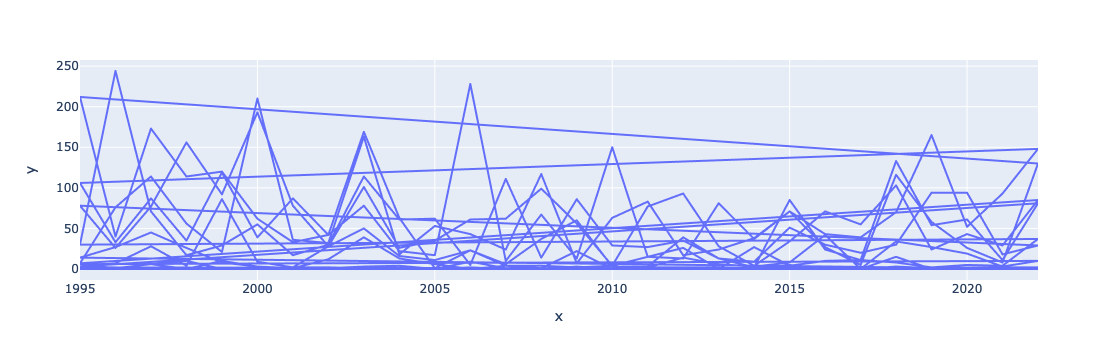

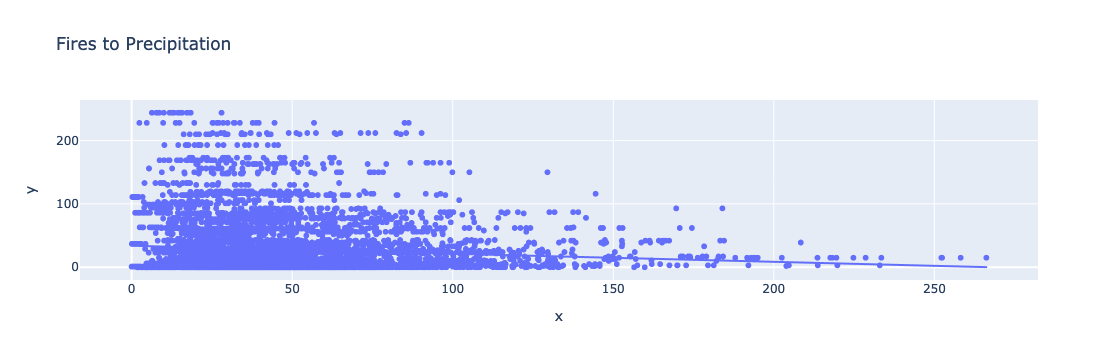

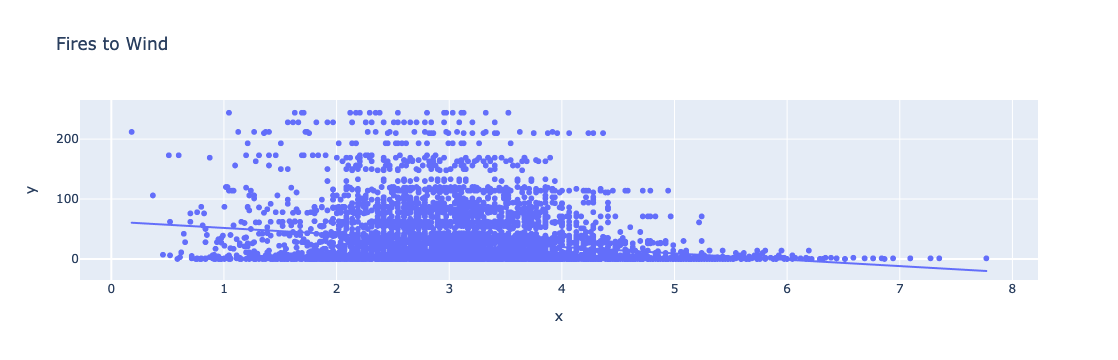

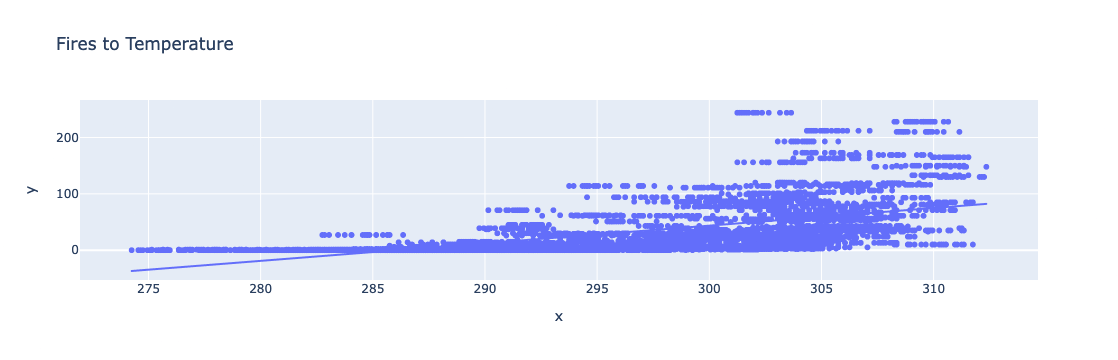

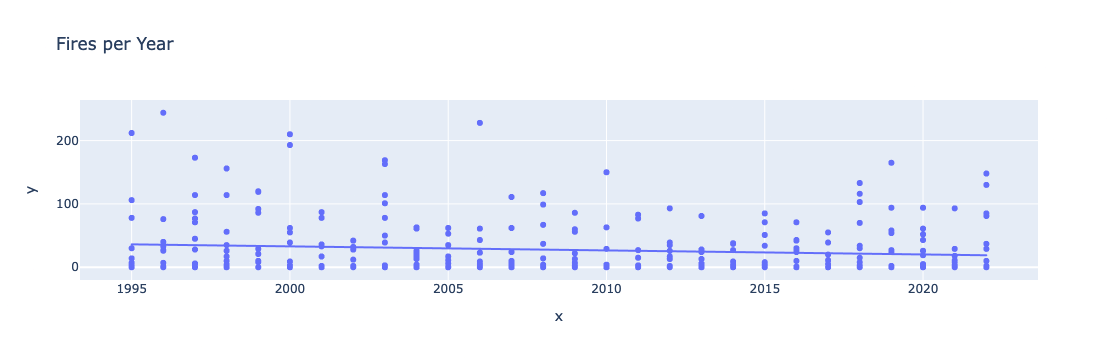

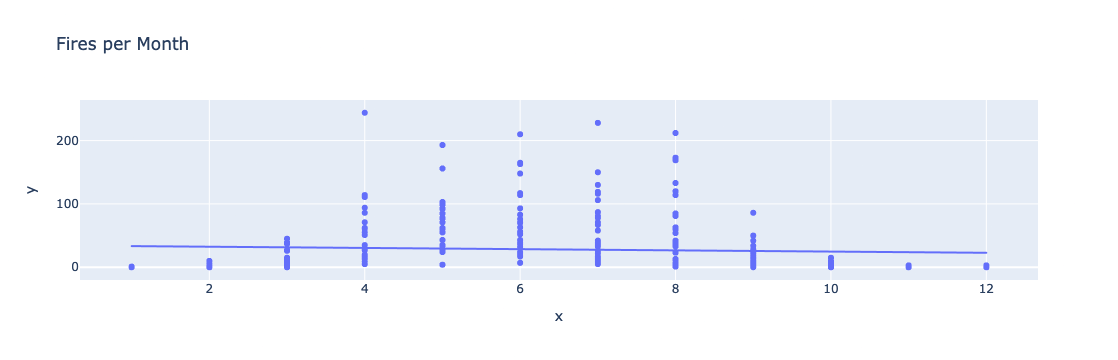

In [67]:
nfplot = pl.line(x=nr["Year"], y = nr["nFires"]) 
fig1 = pl.scatter(x = nr["pr"], y = nr['nFires'], trendline="ols", title='Fires to Precipitation')
fig2 = pl.scatter(x = nr["sfcWind"], y = nr['nFires'], trendline="ols", title='Fires to Wind')
fig3 = pl.scatter(x = nr["tasmax"], y = nr['nFires'], trendline="ols", title='Fires to Temperature')
fig4 = pl.scatter(x = nr["Year"], y = nr['nFires'], trendline="ols", title='Fires per Year')
fig5 = pl.scatter(x = nr["Month"], y = nr['nFires'], trendline="ols", title='Fires per Month')

nfplot.show()
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()

In [68]:
stats = me.compute_statistics(nr, ["tasmax", "pr", "sfcWind"])
stats

['sfcWind', 3.2288464427924826, 0]

In [69]:
nr.nFires.where(nr[['Year']==1995])

KeyError: False

In [70]:
nr['Month'].val

AttributeError: 'Series' object has no attribute 'val'

In [71]:
dffbb = pd.read_csv(common_paths.DATA.joinpath("dwd/future_Brandenburg.csv"))

In [72]:
dffbb.drop(columns=['Unnamed: 0', 'Bundesland'], inplace = True)

In [73]:
dffbb['pr'] = dffbb['pr'] * 3600 * 24 * 30

In [15]:
merge_all = pd.merge(mdf, dffbb, on=["Year", "Month", 'sfcWind', 'tasmax', 'pr'], how='outer')

In [16]:
merge_all.drop(columns=["station_id"], inplace=True)

In [17]:
merge_all

Year  Month         pr   sfcWind     tasmax  nFires
0      1995      1  42.500000  5.380473  285.35000     0.0
1      1995      1  43.500000  5.103005  285.75000     0.0
2      1995      1  71.300000  3.147236  285.65000     0.0
3      1995      1  47.100000  3.791684  286.15000     0.0
4      1995      1  52.000000  5.218021  285.75000     0.0
...     ...    ...        ...       ...        ...     ...
78771  2054      1  41.612901  4.516129  274.10160     NaN
78772  2054      1  51.967742  5.196774  273.57257     NaN
78773  2054      1  51.967742  5.316129  273.62740     NaN
78774  2054      1  45.483872  5.216129  273.60483     NaN
78775  2054      1  47.419354  5.241936  273.66290     NaN

[78776 rows x 6 columns]

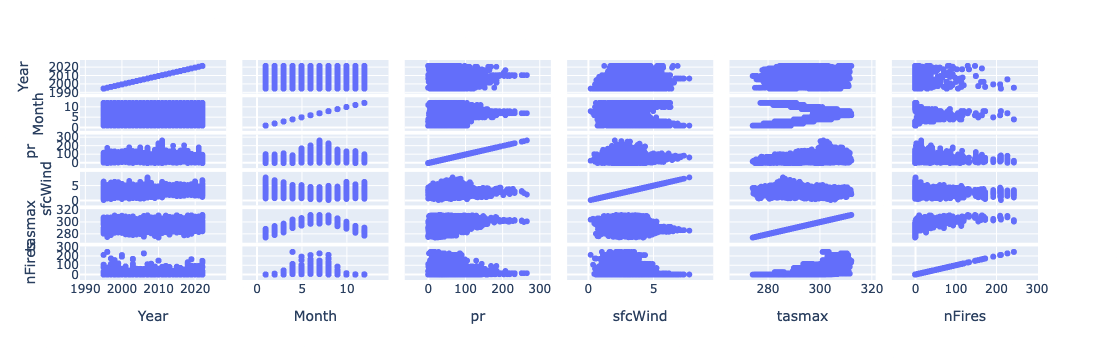

In [25]:
scat = pl.scatter_matrix(mdf)
scat.show()

In [26]:
mdf.describe()

Year        Month           pr      sfcWind       tasmax  \
count  6620.000000  6620.000000  6620.000000  6620.000000  6620.000000   
mean   2007.628852     6.503776    46.181541     3.228846   295.053776   
std       7.679455     3.466127    30.383094     0.928339     8.696294   
min    1995.000000     1.000000     0.000000     0.180576   274.250000   
25%    2001.000000     3.000000    26.075000     2.598817   287.225000   
50%    2007.000000     7.000000    39.800000     3.166764   295.450000   
75%    2014.000000    10.000000    59.500000     3.791684   302.950000   
max    2022.000000    12.000000   266.200000     7.768545   312.350000   

            nFires  
count  6620.000000  
mean     28.099547  
std      43.975493  
min       0.000000  
25%       0.000000  
50%       6.000000  
75%      37.000000  
max     244.000000

<Axes: >

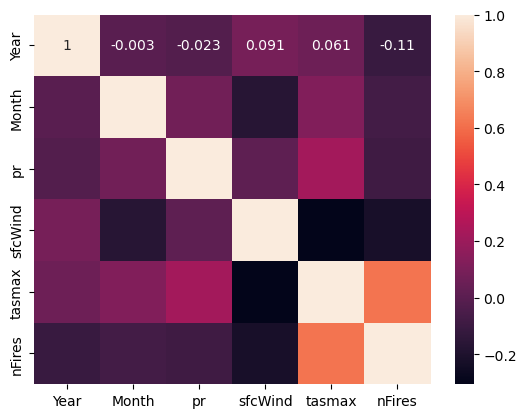

In [78]:
'''
Achtung hier lineare korrelationen -> hoch heißt korrelation ist stark aber niedrig kann andere art von korrelation sein
(BSP regen zu feuer)
'''
sb.heatmap(nr.corr(), annot=True)

In [75]:
nr.corr()

Year     Month        pr   sfcWind    tasmax    nFires
Year     1.000000 -0.003038 -0.022764  0.091451  0.060791 -0.111551
Month   -0.003038  1.000000  0.074382 -0.170993  0.117366 -0.075584
pr      -0.022764  0.074382  1.000000  0.010522  0.219663 -0.087637
sfcWind  0.091451 -0.170993  0.010522  1.000000 -0.306115 -0.224123
tasmax   0.060791  0.117366  0.219663 -0.306115  1.000000  0.618533
nFires  -0.111551 -0.075584 -0.087637 -0.224123  0.618533  1.000000

In [80]:
test_size=0.2
random_state=42
str_parameter_list = [str(param) for param in parameter_list]
feature_list = ["sfcWind", "pr", "tasmax"]
X = nr[feature_list]
y = nr["nFires"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

print(y_train)
# results = evaluate_model(X_train, X_test, y_train, y_test)

6367      0.0
6519      0.0
1895      4.0
3117     99.0
4088    165.0
        ...  
4762    116.0
6554      9.0
6590      1.0
6795      5.0
1034      1.0
Name: nFires, Length: 5296, dtype: float64


In [82]:
param_grid = {
    "n_estimators": [300],
    "max_depth": [10],  # Smaller range for max depth
    "min_samples_leaf": [1],
    "min_samples_split": [10]
}
rf = RandomForestRegressor()

grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

#searching for the right parameters using random Forest on a 10-fold Cross Validation (cv) and the nmse
grid_search.fit(X_train, y_train)

# saving best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [83]:
print(best_params)
print(best_model)
#grid_search.cv_results_
#grid_search.best_index_

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=300)


In [84]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


#predict 'Anzahl Waldbrände' with the model
y_pred = best_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"MAE: {mae}")

MSE: 788.3413610465408
R2 Score: 0.5915383131117252
MAE: 16.038438885986384


In [85]:
X_dffbb = dffbb[feature_list]

In [91]:
print(X_dffbb)
print(X)

        sfcWind         pr     tasmax
0      4.900000  51.580644  278.43063
1      4.761291  54.774196  278.38547
2      4.422581  63.967742  278.19840
3      4.416129  47.709679  278.55966
4      4.367742  47.709679  278.54030
...         ...        ...        ...
70390  4.516129  41.612901  274.10160
70391  5.196774  51.967742  273.57257
70392  5.316129  51.967742  273.62740
70393  5.216129  45.483872  273.60483
70394  5.241936  47.419354  273.66290

[70395 rows x 3 columns]
       sfcWind    pr  tasmax
0     5.380473  42.5  285.35
1     5.103005  43.5  285.75
2     3.147236  71.3  285.65
3     3.791684  47.1  286.15
4     5.218021  52.0  285.75
...        ...   ...     ...
8370  2.897073  37.2  290.65
8371  2.897073  40.7  290.65
8373  4.409306  58.8  290.45
8377  2.897073  45.4  289.95
8380  2.840331  40.7  290.05

[6620 rows x 3 columns]


In [96]:
predictions = best_model.predict(dffbb[feature_list])

In [95]:
final_predictions = predictions.join(X_dffbb)

AttributeError: 'numpy.ndarray' object has no attribute 'join'

In [92]:
print(predictions)

[0.01083425 0.01083425 0.01203083 ... 0.01637943 0.01654203 0.01654203]


In [23]:
feature_list = ["sfcWind", "pr", "tasmax"]
X = dffbb[feature_list]

In [24]:
param_grid = {
    "n_estimators": [300],
    "max_depth": list(10),  # Smaller range for max depth
    "min_samples_leaf": [1],
    "min_samples_split": [10]
}
rf = RandomForestRegressor()

grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

#searching for the right parameters using random Forest on a 10-fold Cross Validation (cv) and the nmse
grid_search.fit(X_train, y_train)

# saving best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

TypeError: 'int' object is not iterable

In [ ]:
predictions = best_model.predict(X_test_main)